In [ ]:
!pip install tensorflow
!pip install opencv-python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import time
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
from tqdm import tqdm
import cv2
from keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore')

In [ ]:
img_train_path = "/content/drive/MyDrive/ML/extracted_data/Train"
img_test_path = "/content/drive/MyDrive/ML/extracted_data/Test"
data_gen = ImageDataGenerator(rescale=1./255, fill_mode='reflect')
val_gen = ImageDataGenerator(rescale=1./255)

train_gen = data_gen.flow_from_directory(img_train_path, target_size=(256,256), batch_size=128)
validation_gen = val_gen.flow_from_directory(img_test_path, target_size=(256,256), batch_size=128)

Found 4554 images belonging to 10 classes.
Found 496 images belonging to 10 classes.


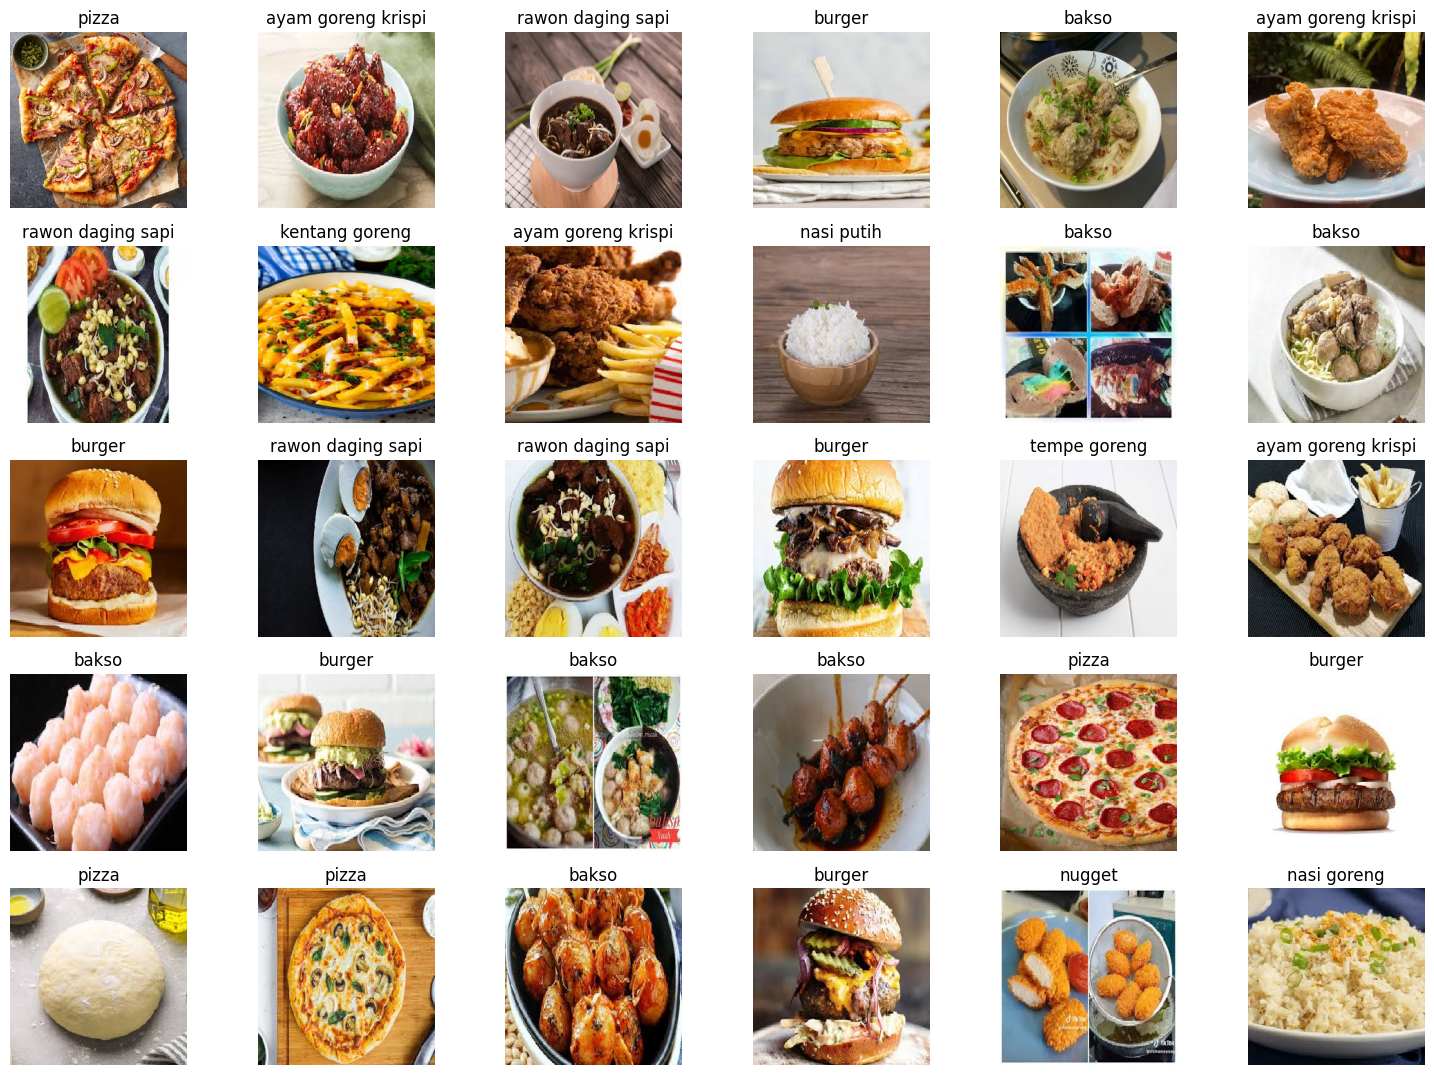

In [ ]:
img, labels = next(train_gen)

class_names = ['ayam goreng krispi', 'bakso', 'burger', 'kentang goreng',
               'nasi goreng', 'nasi putih', 'nugget', 'pizza',
               'rawon daging sapi', 'tempe goreng']

plt.figure(figsize=(15, 13))
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])
    class_index = np.argmax(labels[i])
    plt.title(class_names[class_index])
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
x_data = []
y_data = []

for category in glob(img_train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 461/461 [00:09<00:00, 48.76it/s]


In [ ]:
data.shape

(4554, 2)

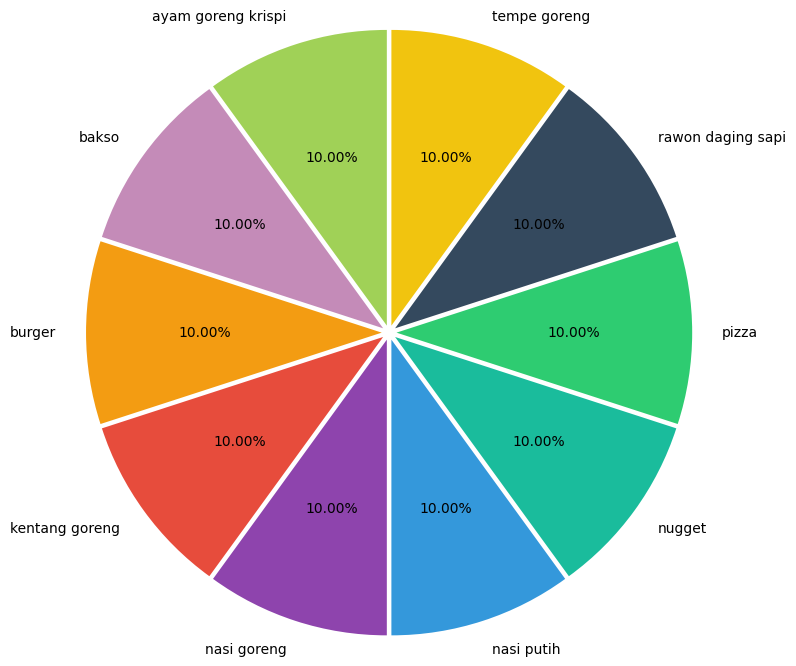

In [ ]:
data = pd.DataFrame({
    'label': ['ayam goreng krispi', 'bakso', 'burger', 'kentang goreng', 'nasi goreng',
              'nasi putih', 'nugget', 'pizza', 'rawon daging sapi', 'tempe goreng'] * 10
})

class_counts = data['label'].value_counts().sort_index().values

colors = ['#a0d157','#c48bb8','#f39c12','#e74c3c','#8e44ad','#3498db','#1abc9c','#2ecc71','#34495e','#f1c40f']

explode = [0.05] * 10

labels = ['ayam goreng krispi', 'bakso', 'burger', 'kentang goreng', 'nasi goreng', 'nasi putih', 'nugget', 'pizza', 'rawon daging sapi', 'tempe goreng']

plt.pie(class_counts, startangle=90, explode=explode, autopct='%0.2f%%', labels=labels, colors=colors, radius=2)
plt.show()

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.001)))
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.001)))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.001)))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

model.compile(optimizer='Nadam',loss='CategoricalCrossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

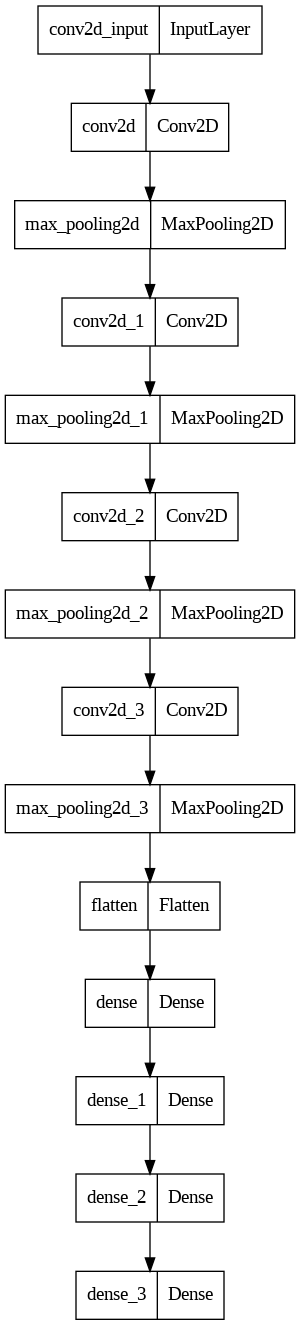

In [ ]:
plot_model(model)

In [ ]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

best_model = ModelCheckpoint('/content/drive/MyDrive/ML/model versi ringan/cnn.h5', monitor='val_loss', save_best_only=True)

In [ ]:
history = model.fit(train_gen, validation_data=validation_gen, epochs=30, callbacks=[best_model, early_stopping_monitor])

Epoch 1/30
36/36 [==============================] - 340s 9s/step - loss: 2.9846 - accuracy: 0.1487 - val_loss: 2.5565 - val_accuracy: 0.1794
Epoch 2/30
36/36 [==============================] - 49s 1s/step - loss: 2.3117 - accuracy: 0.2664 - val_loss: 2.0012 - val_accuracy: 0.4214
Epoch 3/30
36/36 [==============================] - 53s 1s/step - loss: 2.0058 - accuracy: 0.3825 - val_loss: 1.8319 - val_accuracy: 0.4839
Epoch 4/30
36/36 [==============================] - 47s 1s/step - loss: 1.7996 - accuracy: 0.4633 - val_loss: 1.3698 - val_accuracy: 0.6331
Epoch 5/30
36/36 [==============================] - 48s 1s/step - loss: 1.5084 - accuracy: 0.5782 - val_loss: 1.1952 - val_accuracy: 0.6915
Epoch 6/30
36/36 [==============================] - 47s 1s/step - loss: 1.3489 - accuracy: 0.6293 - val_loss: 1.0354 - val_accuracy: 0.7641
Epoch 7/30
36/36 [==============================] - 42s 1s/step - loss: 1.2313 - accuracy: 0.6814 - val_loss: 1.0930 - val_accuracy: 0.7238
Epoch 8/30
36/36 [=

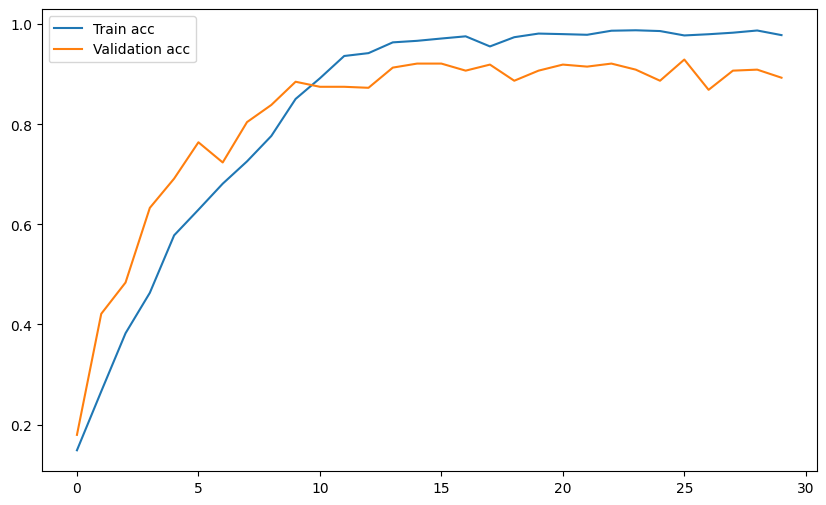

In [ ]:
plt.figure(figsize=[10,6])
plt.plot(history.history["accuracy"], label = "Train acc")
plt.plot(history.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/ML/model versi ringan/cnn.h5")

In [ ]:
model.load_weights('/content/drive/MyDrive/ML/model versi ringan/cnn.h5')
model.evaluate(validation_gen);

4/4 [==============================] - 9s 2s/step - loss: 0.7844 - accuracy: 0.8931


In [ ]:
accuracy = model.evaluate_generator(validation_gen)
print("Accuracy:", accuracy)

Accuracy: [0.7843551635742188, 0.8931451439857483]


In [ ]:
img, labels = next(validation_gen)
predictions = model.predict(img)

4/4 [==============================] - 1s 21ms/step


4/4 [==============================] - 0s 21ms/step


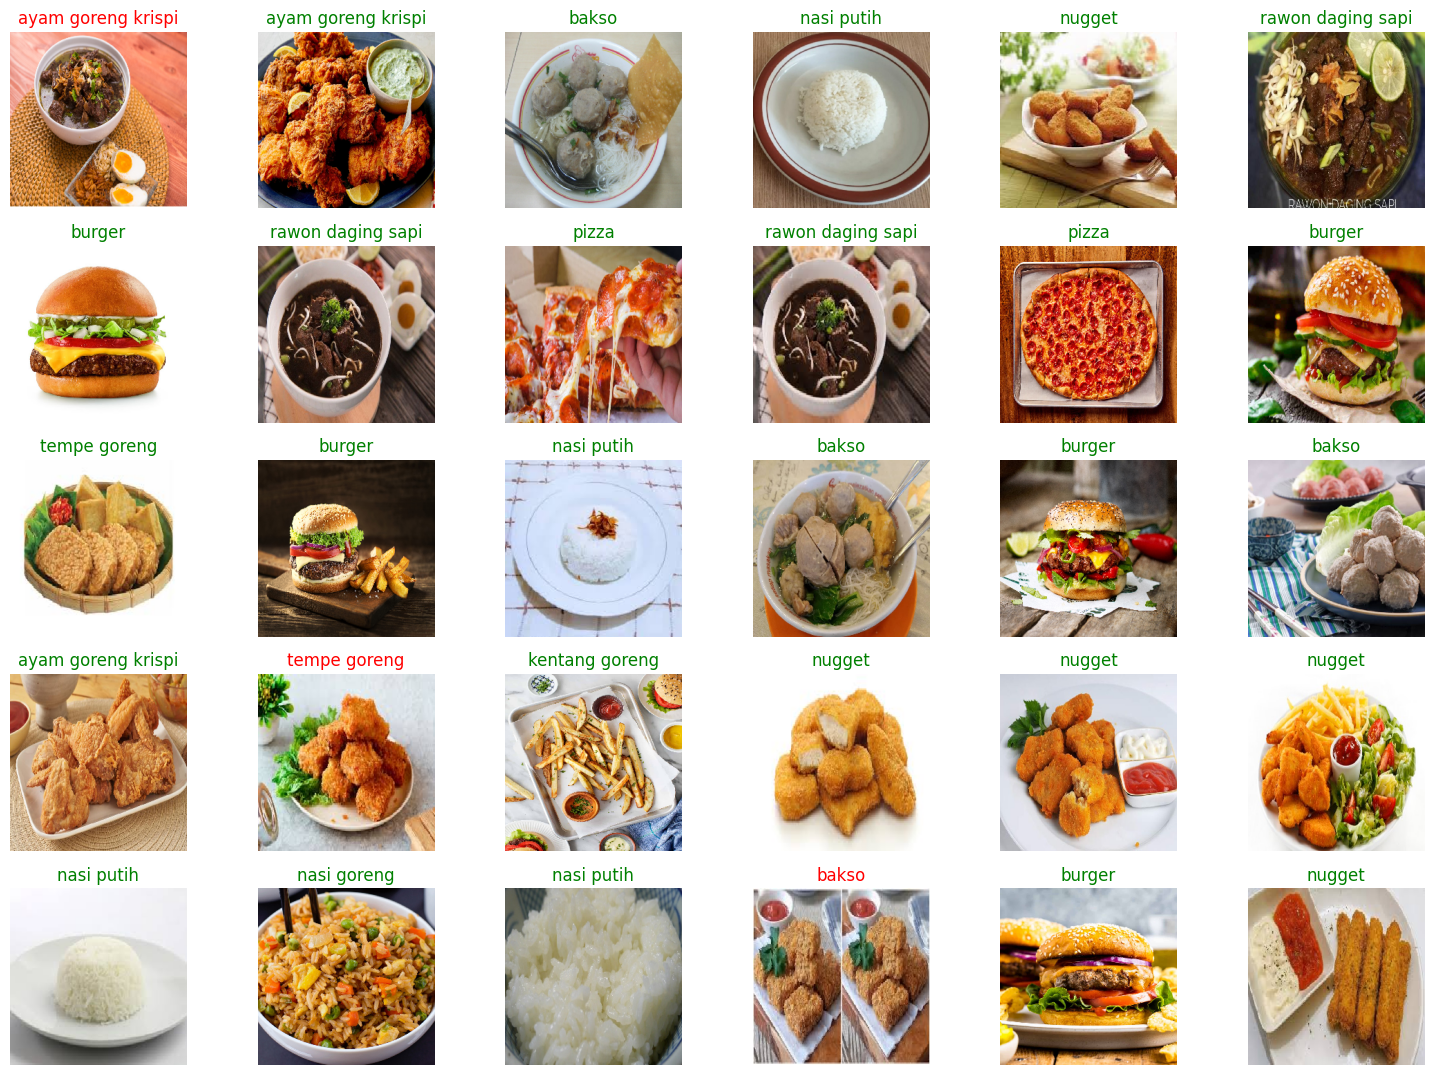

In [ ]:
predictions = model.predict(img)

class_names = ['ayam goreng krispi', 'bakso', 'burger', 'kentang goreng',
               'nasi goreng', 'nasi putih', 'nugget', 'pizza',
               'rawon daging sapi', 'tempe goreng']

plt.figure(figsize=(15, 13))
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])

    pred_label = np.argmax(predictions[i])
    true_label = np.argmax(labels[i])

    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.title(class_names[pred_label], color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
h5_model_path = '/content/drive/MyDrive/ML/model versi ringan/cnn.h5'

model = tf.keras.models.load_model(h5_model_path)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = '/content/drive/MyDrive/ML/model versi ringan/cnn.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model successfully converted and saved at {tflite_model_path}")


Model successfully converted and saved at /content/drive/MyDrive/ML/model versi ringan/cnn.tflite
